In [2]:
# Import necessary libraries
import jax.numpy as jnp
from jax import random, grad, jit, lax, jacrev
from jax.scipy.linalg import inv, svd, eigh, det
from jax.numpy.linalg import norm
from tqdm.auto import tqdm
from sklearn.datasets import make_spd_matrix
from jax_models import visualize_observations, Lorenz96, KuramotoSivashinsky, generate_true_states, generate_localization_matrix
from jax_filters import ensrf_steps, kalman_filter_process, ensrf_step
import jax
import matplotlib.pyplot as plt
from jax.tree_util import Partial
from functools import partial
from jax_vi import KL_gaussian, log_likelihood, KL_sum
jax.config.update("jax_enable_x64", True)
#jax.config.update("jax_debug_nans", True)

N = 10 # number of Monte Carlo samples
F = 8.0
dt = 0.05
num_steps = 250  # Number of time steps
J0 = 0
n = 40   # Number of state variables
key = random.PRNGKey(0)  # Random key for reproducibility
x0 = random.normal(key, (n,))
initial_state  = x0
# Noise covariances
Q = 0.03 * jnp.eye(n)  # Process noise covariance
R = 0.5 * jnp.eye(n)  # Observation noise covariance
# Observation matrix (identity matrix for direct observation of all state variables)
H = jnp.eye(n)

n_ensemble = 5
observation_interval = 1
initial_state = random.normal(random.PRNGKey(0), (n,))  # Initial state
m0 = initial_state
C0 = Q


l96_model = Lorenz96(dt = dt, F = 8)
l96_step = Partial(l96_model.step)
# Generate true states and observations using the Lorenz '96 model

state_transition_function = l96_model.step

jacobian_function = jacrev(l96_step, argnums=0)
jac_func = Partial(jacobian_function)

observations, true_states = generate_true_states(key, num_steps, n, initial_state, H, Q, R, l96_step, observation_interval)

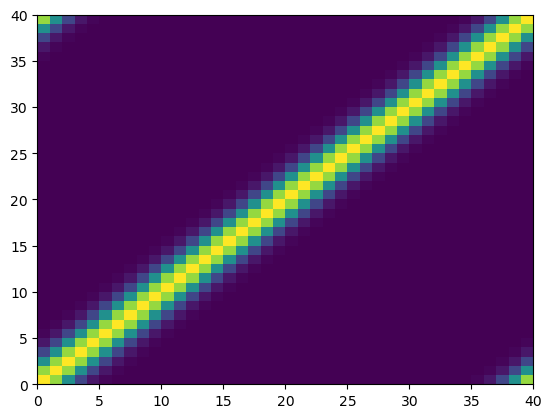

In [3]:
plt.pcolormesh(generate_localization_matrix(40, 2.4))

In [4]:
@jit
def var_cost(radius, inflation, model, ensemble_init, observations, H, Q, R, key, J, J0):
    localization_matrix = generate_localization_matrix(n, radius)
    states, covariances = ensrf_steps(l96_step, n_ensemble, ensemble_init, num_steps, observations, observation_interval, H, Q, R, localization_matrix, inflation, key)
    ensemble_mean = jnp.mean(states, axis=-1)  # Taking the mean across the ensemble members dimension
    key, *subkeys = random.split(key, num=N+1)
    kl_sum = KL_sum(ensemble_mean, covariances, n, model, Q, key, N)
    def inner_map(subkey):
        return log_likelihood(random.multivariate_normal(subkey, ensemble_mean, covariances), observations, H, R, J, J0)  # Sometimes the covariances are negative definite. Fix
    cost = kl_sum - jnp.mean(jax.lax.map(inner_map, jnp.vstack(subkeys)))
    return cost

In [5]:
inflation = 1.5  # Fixed starting value for inflation
radius_opt = 1.0
alpha = 1e-4  # Learning rate
key = random.PRNGKey(0)  # Random key
N = 10  # Number of MC samples
m0 = initial_state
C0 = Q  # Initial covariance, assuming Q is your process noise covariance
ensemble_init = random.multivariate_normal(key, initial_state, Q, (n_ensemble,)).T
localization_matrix = generate_localization_matrix(n, radius_opt)

states, covariances = ensrf_steps(l96_step, n_ensemble, ensemble_init, num_steps, observations, observation_interval, H, Q, R, localization_matrix, inflation, key)


In [6]:
# var_cost_single_obs(radius_opt, inflation, n_ensemble, ensemble_init, observations[0], H, Q, R, key, n, J0)

In [7]:
key, subkey = random.split(key)
var_cost(radius_opt, inflation, l96_step, ensemble_init, observations, H, Q, R, subkey, num_steps, J0)

Array(119137.01306575, dtype=float64)

In [8]:
print(jax.value_and_grad(var_cost) (radius_opt, inflation, l96_step, ensemble_init, observations, H, Q, R, subkey, num_steps, J0))

(Array(119137.01306575, dtype=float64), Array(-51702.69880353, dtype=float64))


In [9]:
# for radius_opt in jnp.arange(0.1, 3, 0.1):
#     print(radius_opt, jax.value_and_grad(var_cost) (radius_opt, inflation, l96_step, ensemble_init, observations, H, Q, R, subkey, num_steps, J0))

In [10]:
ensemble_init.shape

(40, 5)

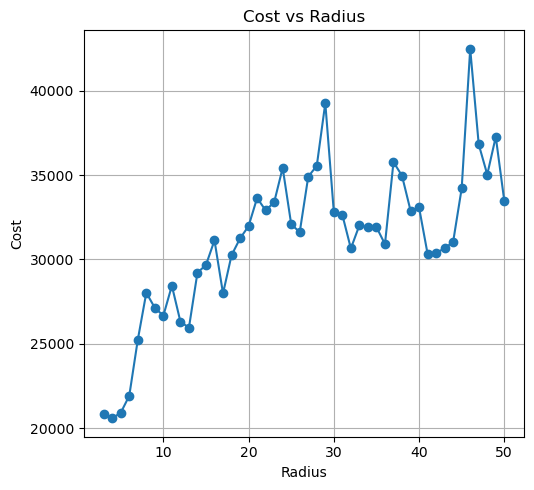

In [11]:
radius_range = jnp.arange(3, 51, 1)  # from 3 to 40 with step size 1
inflation = 1.05
radius_values = []
cost_values = []

for radius_opt in radius_range:
    cost = var_cost(radius_opt, inflation, l96_step, ensemble_init, observations, H, Q, R, subkey, num_steps, J0)
    radius_values.append(radius_opt)
    cost_values.append(cost)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(radius_values, cost_values, label='Cost', marker='o')
plt.title('Cost vs Radius')
plt.xlabel('Radius')
plt.ylabel('Cost')
plt.grid(True)


plt.tight_layout()
plt.show()


In [12]:
var_cost_grad = grad(var_cost, argnums=0)
radius_opt = 5.5
var_cost_grad(radius_opt, inflation, l96_step, ensemble_init, observations, H, Q, R, subkey, num_steps, J0)


Array(1002.34075499, dtype=float64)

In [13]:
base_m, base_C, base_K = kalman_filter_process(l96_step, jac_func, m0, C0, observations, H, Q, R)


In [14]:
n_ensemble

5

In [33]:
import properscoring
from IPython.display import clear_output
from jax import grad
from tqdm.notebook import tqdm
import jax.numpy as jnp
from jax import random


var_cost_grad = grad(var_cost, argnums=0)

inflation = 1.05  # Fixed starting value for inflation
radius_opt = 7.0
alpha = 1e-3  # Learning rate
key = random.PRNGKey(0)  # Random key
N = 10  # Number of MC samples
m0 = initial_state
C0 = Q  # Initial covariance, assuming Q is your process noise covariance
ensemble_init = random.multivariate_normal(key, initial_state, Q, (n_ensemble,)).T

crpss = []
radii = []
rmses=[]
true_div = []
costs = []


for i in tqdm(range(100)):
    key, subkey = random.split(key)
        
    # Gradient descent step for inflation parameter
    current_cost = var_cost(radius_opt, inflation, l96_step, ensemble_init, observations, H, Q, R, subkey, num_steps, J0)
    costs.append(current_cost)
    grad_radius = var_cost_grad(radius_opt, inflation, l96_step, ensemble_init, observations, H, Q, R, subkey, num_steps, J0)
    radius_opt -= alpha * grad_radius  # Update inflation parameter
    radii.append(radius_opt)
    localization_matrix = generate_localization_matrix(n, radius_opt)

    predicted_states, covariances = ensrf_steps(l96_step, n_ensemble, ensemble_init, num_steps, observations, observation_interval, H, Q, R, localization_matrix, inflation, key)
    ensemble_mean = jnp.mean(predicted_states, axis=-1)  # Taking the mean across the ensemble members dimension
    rmse = jnp.sqrt(jnp.mean((ensemble_mean - true_states)**2))
    print(radius_opt, grad_radius, rmse)
    rmses.append(rmse)
    crps = properscoring.crps_ensemble(true_states, states).mean(axis=1).mean()
    crpss.append(crps)
    total_kl_divergence = 0
    for t in range(num_steps):  
        kl_div_t = KL_gaussian(n, ensemble_mean[t], covariances[t],  base_m[t], base_C[t])
        total_kl_divergence += kl_div_t 
    true_div.append(total_kl_divergence / num_steps)
    

  0%|          | 0/100 [00:00<?, ?it/s]

4.631982216085094 2368.017783914906 0.5454786137718781
4.252251877621005 379.730338464088 0.526263775284623
4.149850486425727 102.40139119527831 0.5218958305412111
4.18470076713963 -34.8502807139035 0.5233483069321907
4.164639582812325 20.061184327305497 0.5225080074322181
4.086992083867023 77.64749894530169 0.519361286827662
4.051705760471016 35.28632339600743 0.5179850524600176
4.073057210005146 -21.35144953412997 0.518813869901846
4.077181893923071 -4.124683917925182 0.518975366270197
4.1319712877598445 -54.78939383677344 0.5211638973142937
4.097634707763551 34.33657999629294 0.5197828620133996
4.054027703900019 43.6070038635326 0.5180746058858066
4.051649787873008 2.377916027010542 0.5179828954290707
4.011854418116247 39.79536975676118 0.5164698115990805
3.9959540416134036 15.900376502843308 0.5158765861279355
4.11084029904999 -114.8862574365864 0.5203102010978605
4.0484606641595375 62.379634890451975 0.5178601302461533
4.016071903908789 32.388760250748334 0.5166282395637651
4.0559

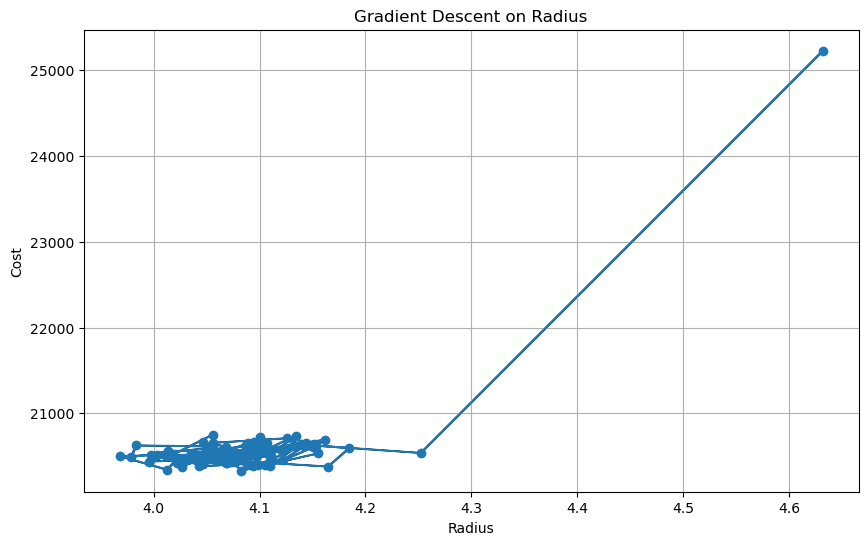

In [35]:
#Visualize Descent
plt.figure(figsize=(10, 6))
plt.plot(radii, costs, marker='o')
plt.xlabel('Radius')
plt.ylabel('Cost')
plt.title('Gradient Descent on Radius')
plt.grid(True)

for i in range(len(radii) - 1):
    plt.arrow(radii[i], costs[i], radii[i + 1] - radii[i], costs[i + 1] - costs[i],  fc='k', ec='k')

plt.show()

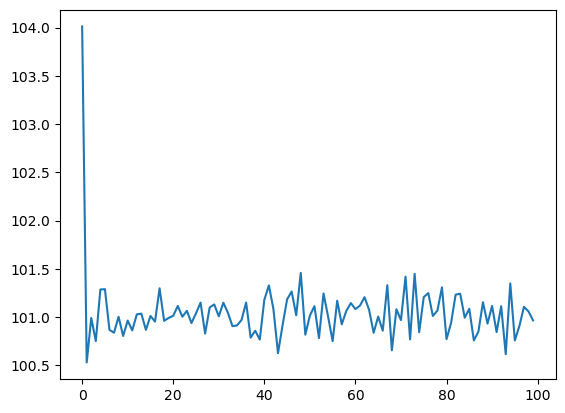

In [51]:
plt.plot(radii)

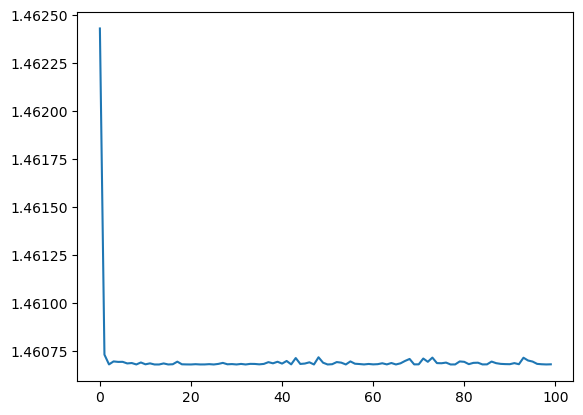

In [52]:
plt.plot(rmses)

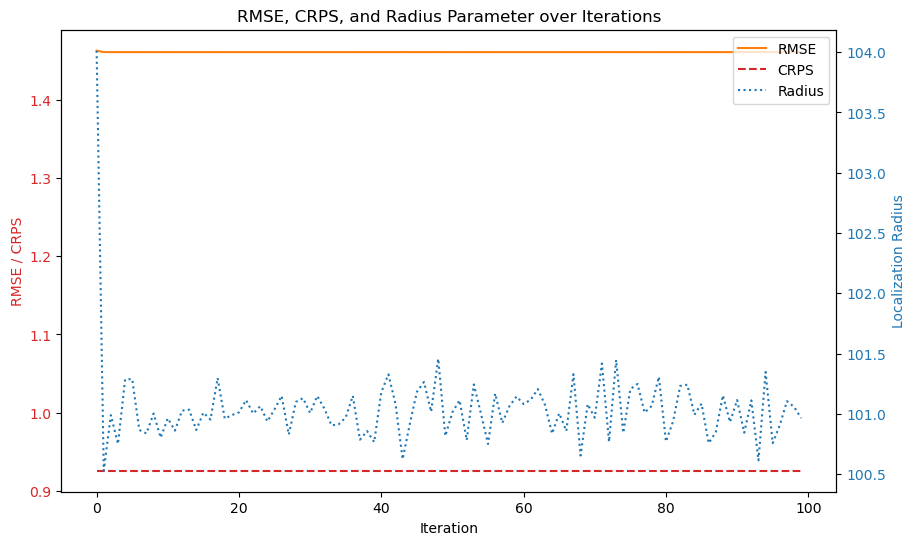

In [53]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting the RMSE and CRPS on the primary y-axis
color = 'tab:red'
ax1.set_xlabel('Iteration')
ax1.set_ylabel('RMSE / CRPS', color=color)
ln1 = ax1.plot(rmses, label='RMSE', color='tab:orange', linestyle='-')
ln2 = ax1.plot(crpss, label='CRPS', color='tab:red', linestyle='--')
ax1.tick_params(axis='y', labelcolor=color)

# Create a twin y-axis for the inflation parameter
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Localization Radius', color=color)
ln3 = ax2.plot(radii, label='Radius', color=color, linestyle=':')
ax2.tick_params(axis='y', labelcolor=color)

# Combine legends from both axes
lns = ln1 + ln2 + ln3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='upper right')

plt.title('RMSE, CRPS, and Radius Parameter over Iterations')
plt.show()


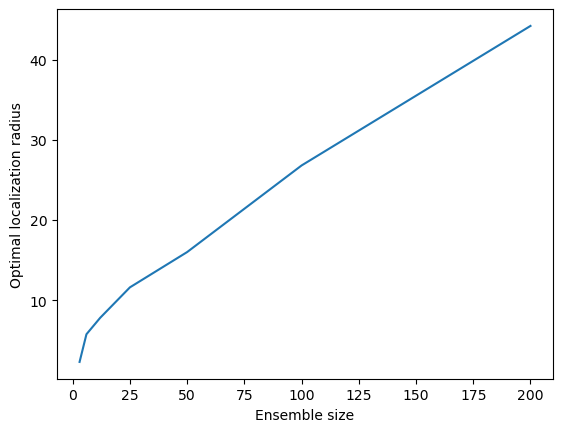

In [13]:
plt.plot([3, 6, 12, 25, 50, 100, 200], [2.3, 5.75, 7.8, 11.6, 16, 26.8, 44.2])
plt.xlabel("Ensemble size")
plt.ylabel("Optimal localization radius")
plt.savefig("localization_radii.pdf")